## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *

### Load data and preprocess

In [2]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad') # read in one of the annotated example files

CPU times: user 4.02 s, sys: 804 ms, total: 4.83 s
Wall time: 5.01 s


In [3]:
s1 # see contents of AnnData object

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

Standard preprocessing to get metadata for barcodes:

In [4]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# save raw counts in layer
s1.layers['raw_counts'] = s1.X.copy()

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 3.97 s, sys: 1.97 s, total: 5.94 s
Wall time: 6.95 s


In [5]:
%%time
# normalize, scale, and perform PCA
sc.pp.normalize_total(s1, target_sum=10000)
sc.pp.log1p(s1)

# save log1p-transformed counts in layer
s1.layers['log1p_counts'] = s1.X.copy()

# scale and perform PCA
sc.pp.scale(s1, max_value=10)
sc.tl.pca(s1, n_comps=500)

CPU times: user 1min 57s, sys: 3.92 s, total: 2min 1s
Wall time: 1min 7s


In [6]:
%%time 
# generate neighborhood graph, cluster with louvain, and perform PAGA analysis
sc.pp.neighbors(s1, n_neighbors=90, random_state=18, n_pcs=500)
sc.tl.louvain(s1, random_state=18)
sc.tl.paga(s1)

CPU times: user 11.7 s, sys: 835 ms, total: 12.6 s
Wall time: 11.7 s


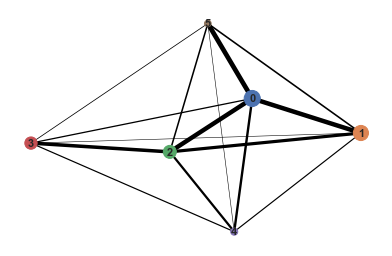

In [7]:
# show PAGA diagram of cluster similarity
sc.pl.paga(s1, frameon=False)

In [8]:
# perform UMAP using PAGA to initialize
%time sc.tl.umap(s1, init_pos=sc.tl._utils.get_init_pos_from_paga(s1), random_state=18)

CPU times: user 24.7 s, sys: 112 ms, total: 24.8 s
Wall time: 25.4 s


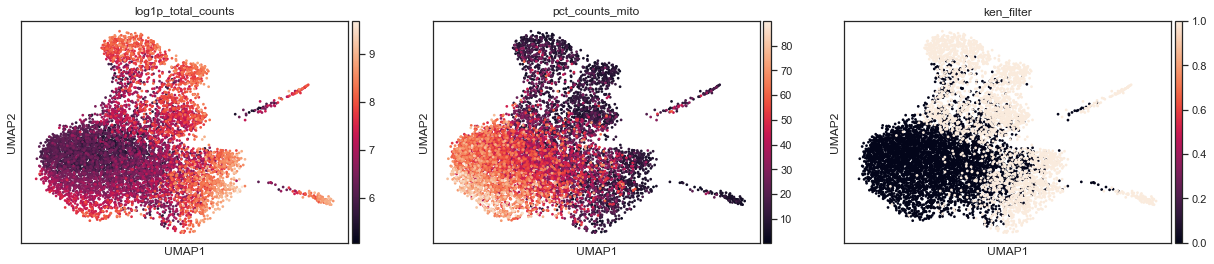

In [9]:
# show barcodes with low counts, high mito, and Ken's filter
sc.pl.umap(s1, color=['log1p_total_counts', 'pct_counts_mito', 'ken_filter'], size=30)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [10]:
from skimage.filters import threshold_li, threshold_otsu, threshold_mean # popular thresholding methods

In [11]:
# use a few methods on the log-transformed total counts for each barcode:
thresh_otsu = threshold_otsu(np.array(s1.obs['log1p_total_counts']))
thresh_li = threshold_li(np.array(s1.obs['log1p_total_counts']))
thresh_mean = threshold_mean(np.array(s1.obs['log1p_total_counts']))

Plot thresholds on `log1p_total_counts`:

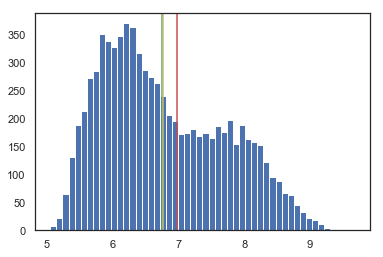

In [12]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu threshold
plt.axvline(thresh_li, color='g') # li threshold
plt.axvline(thresh_mean, color='y') # mean threshold

### Find inflection point

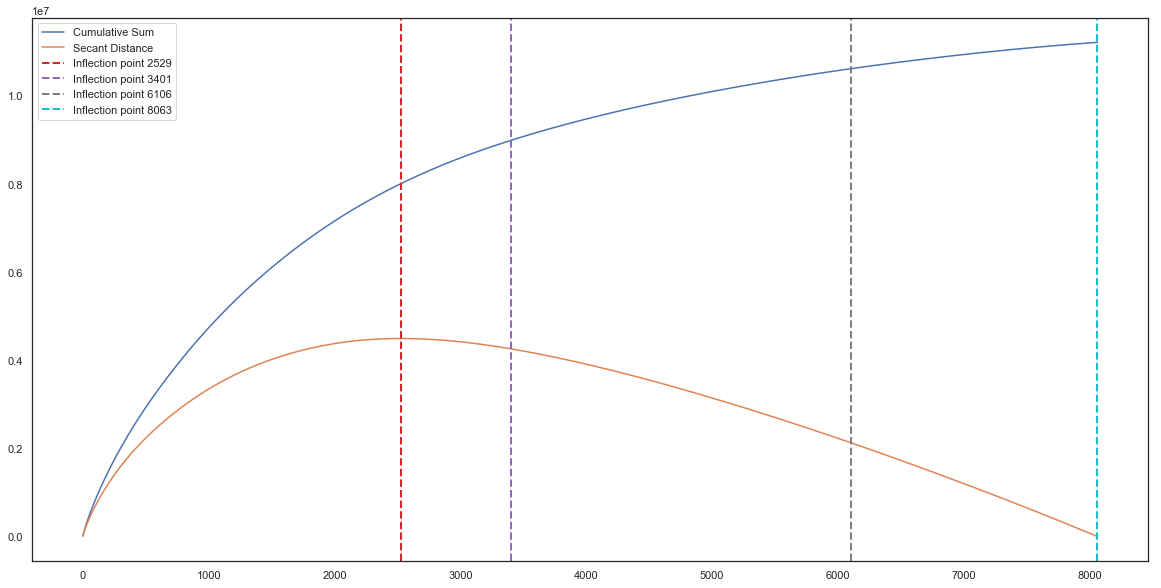

Inflection point at index
bcFJXN    2529
bcFXFE    3401
bcFOEH    6106
bcEBWV    8063
Name: total_counts, dtype: int64 for [0, 20, 70, 100] percentiles of greatest secant distances


{0: 2529, 20: 3401, 70: 6106, 100: 8063}

In [13]:
# inflection_percentiles are percentages of maximum secant distance. we wanna pick one to the right of the maximum
find_inflection(s1, inflection_percentiles = [0,20,70,100], output_prefix='')

The purple cutoff looks pretty good if we were manually filtering the data. Let's see how many total counts and log1p-transformed total counts the cell at that position has:

In [14]:
s1.obs['log1p_total_counts'][3401] # see the log-transformed total counts for the cutoff point; this should be close to otsu or li threshold

6.8079348

So the above number should correspond to a cutoff between the two 'lumps' in our `log1p_total_counts` distribution, and it looks close to our `Otsu`, `mean`, and `Li` thresholds.  
Let's plot it to compare to the automated thresholds from `skimage`:

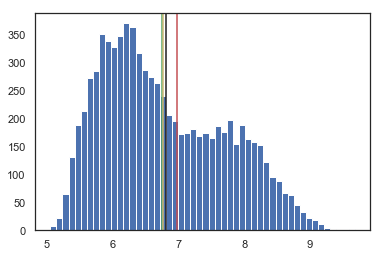

In [15]:
_ = plt.hist(s1.obs['log1p_total_counts'], bins=50)
plt.axvline(thresh_otsu, color='r') # otsu
plt.axvline(thresh_li, color='g') # li
plt.axvline(thresh_mean, color='y') # mean threshold
plt.axvline(s1.obs['log1p_total_counts'][3401], color='k') # threshold chosen from one of the inflection point percentage cutoffs

Li and Mean thresholding line up pretty well with what we would choose beyond inflection point.

---
Now, we want to generate a training set from the barcodes __below__ our `log1p_total_counts` threshold.  
To do so, we will randomly sample a reasonable number of barcodes (>1000), with probabilities __decreasing__ with __increasing total counts__.

In [16]:
# initialize 'probabilities' column with all zeros. we want probability of drawing a barcode ABOVE our threshold to be ZERO
s1.obs['train_prob'] = 0

# of all the barcodes BELOW our threshold (using Li here), take the reciprocal of their total counts and normalize to the sum
s1.obs.loc[s1.obs['log1p_total_counts']<thresh_li, 'train_prob'] = np.reciprocal(s1.obs.loc[s1.obs['log1p_total_counts']<thresh_li, 'total_counts']+1)
s1.obs['train_prob'] /= s1.obs['train_prob'].sum()

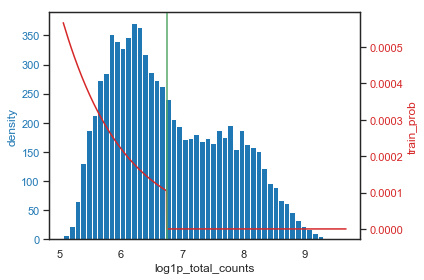

In [17]:
# plot the probability of drawing a barcode for our training set versus the log1p_total_counts
# there should be a dropoff to ZERO at the threshold value we chose
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('log1p_total_counts')
ax1.set_ylabel('density', color=color)
ax1.hist(s1.obs['log1p_total_counts'], bins=50, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('train_prob', color=color)  # we already handled the x-label with ax1
ax2.plot(s1.obs['log1p_total_counts'], s1.obs['train_prob'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(thresh_li, color='g') # li threshold

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [18]:
# now randomly sample a training set using s1.obs['train_prob'] from above as the vector of probabilities.
# save sample as label in adata.obs['train']
s1.obs['train'] = 0
s1.obs.iloc[np.random.choice(a=s1.obs.shape[0], size=2000, replace=False, p=s1.obs['train_prob']),s1.obs.columns.get_loc('train')] = 1

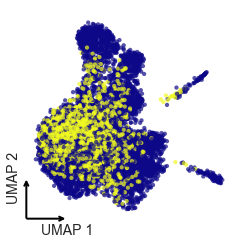

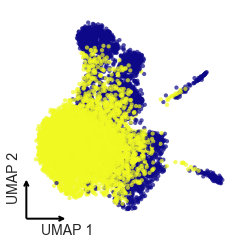

In [19]:
DR_plot(dim_name='UMAP', figsize=(3.5,3.5)).plot_IDs(s1, use_rep='X_umap', obs_col='train', pt_size=18)
DR_plot(dim_name='UMAP', figsize=(3.5,3.5)).plot_IDs(s1, use_rep='X_umap', obs_col='ken_filter', pt_size=18)

Compare our training set to Ken's filter.  
We want a small number here, but <= 50 is acceptable, since our machine learning classifier will work out the kinks...

In [20]:
len(set(s1.obs.loc[s1.obs['ken_filter']==1].index).difference(set(s1.obs.loc[s1.obs['train']==0].index)))

29